In [ ]:
import os
import random

import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta, MO
import calendar
import numpy as np
import pandas as pd
from numpy import sqrt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error as MSE, accuracy_score, f1_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from statistics import variance
from scipy.ndimage.filters import gaussian_filter1d

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout, Dense, GRU
from keras.layers import concatenate

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('mode.chained_assignment', None)
parser = lambda x: datetime.strptime(x, '%Y-%m-%d')

## Define feature functions

In [ ]:
# Identify Wednesday

def is_wednesday(df):
  df['Weekday'] = df['Date'].dt.dayofweek
  df['Month'] = df['Date'].dt.month

  def is_wednesday(weekday):
    if weekday == 2:
      return 1
    else:
      return 0

  df['isWednesday'] = df['Weekday'].apply(lambda DOW : is_wednesday(DOW))

  return df

In [ ]:
def last_Wednesday_date(df):
  df['Last_Wednesday_Date'] = np.nan

  for idx, row in df.iterrows():

    date = df.Date[idx]
    day_of_week = date.weekday()
    # Calculate how many days until the last day of the month
    last_day = datetime.date(date.year, date.month, 1) + timedelta(days=32)
    last_day = last_day.replace(day=1) - timedelta(days=1)
    num_days_to_last_day = last_day.day - date.day
    

    # Calculate how many days until the last Wednesday of the month
    num_days_to_last_wednesday = (7 + 3 - day_of_week) % 7 + num_days_to_last_day

    # Add the number of days until the last Wednesday to the current date to get the last Wednesday of the month
    last_wednesday = date + timedelta(days=num_days_to_last_wednesday)

    df['Last_Wednesday_Date'][idx] = last_wednesday

  return df

In [ ]:
# Flag if last wednesday of the month

def is_last_wednesday(df):

  df['is_last_wednesday'] = 0

  for index, row in df.iterrows():
    # get the last day of the month for the date in the row
    last_day_of_month = pd.to_datetime(row['Date'].strftime('%Y-%m-') + '01') + pd.offsets.MonthEnd(1)
    # get the last Wednesday of the month
    last_wednesday_of_month = last_day_of_month - pd.offsets.Week(weekday=2)
    # check if the date in the row is the last Wednesday of the month
    if row['Date'] == last_wednesday_of_month:
      df.loc[index, 'is_last_wednesday'] = 1

  return df

In [ ]:
# Daily absolute variance

def daily_variance(df):
  df['Daily_Variance'] = df.hrc.diff().fillna(np.mean(df['hrc']))

  return df

In [ ]:
# Create time shifts

def create_shifts(df):
  df['hrc_L5'] = df['hrc'].shift(5).fillna(np.mean(df['hrc']))
  df['hrc_L10'] = df['hrc'].shift(10).fillna(np.mean(df['hrc']))
  df['hrc_L15'] = df['hrc'].shift(15).fillna(np.mean(df['hrc']))

  return df

In [ ]:
def calculate_mean_variance(df, colname, period):

  # Calculate the difference between each row and the previous row
  df['diff'] = df['hrc'].diff()

  # Calculate the rolling mean for the last 10 rows
  df[colname] = df['diff'].rolling(period).mean()

  df[colname] = df[colname].bfill()

  return df

In [ ]:
# Create time features

def create_time_features(df, label=None):
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day

    return df

In [ ]:
# last wednesday hrc price

def return_last_wednesday_hrc(df):
  df['Last_Wednesday_HRC'] = np.nan
  df['Last_Wednesday_Date'] = np.nan

  for idx, row in df.iterrows():
    try:

      wednesday_check = 0
      for i in range(0, 30):
        wednesday_check = df['is_last_wednesday'][idx + i]
        if wednesday_check == 1:
          next_wed_idx = idx + i

          break

      df['Last_Wednesday_HRC'][idx - 1: next_wed_idx] = df['hrc'][next_wed_idx]
      df['Last_Wednesday_Date'][idx - 1: next_wed_idx] = df['Date'][next_wed_idx]

    except Exception as e:
      pass

  df['Last_Wednesday_HRC'] = df['Last_Wednesday_HRC'].ffill()
  return df

In [ ]:
raw_data = pd.read_csv('/content/data.csv', parse_dates=True, date_parser=parser)
raw_data['Date'] = pd.to_datetime(raw_data.Date)

In [ ]:
raw_data = pd.read_csv('/content/data.csv', parse_dates=True, date_parser=parser)
raw_data['Date'] = pd.to_datetime(raw_data.Date)

raw_data = is_wednesday(raw_data)
raw_data = is_last_wednesday(raw_data)
raw_data = daily_variance(raw_data)
raw_data = create_shifts(raw_data)
raw_data = create_time_features(raw_data)
raw_data = return_last_wednesday_hrc(raw_data)

In [ ]:
raw_data.head()

,Date,hrc,iron,natural_gas,copper,oil,us_ppi,us_ism_pmi,Weekday,Month,...,hrc_L5,hrc_L10,hrc_L15,quarter,month,year,dayofyear,dayofmonth,Last_Wednesday_HRC,Last_Wednesday_Date
0,2008-10-20,680.0,85.0,6.741,6.741,72.03,148.2,47.2,0,10,...,709.816624,709.816624,709.816624,4,10,2008,294,20,655.0,2008-10-29 00:00:00
1,2008-10-21,680.0,80.0,6.844,6.844,69.72,148.2,47.2,1,10,...,709.816624,709.816624,709.816624,4,10,2008,295,21,655.0,2008-10-29 00:00:00
2,2008-10-22,665.0,80.0,6.777,6.777,64.52,148.2,47.2,2,10,...,709.816624,709.816624,709.816624,4,10,2008,296,22,655.0,2008-10-29 00:00:00
3,2008-10-23,665.0,80.0,6.419,6.419,65.92,148.2,47.2,3,10,...,709.816624,709.816624,709.816624,4,10,2008,297,23,655.0,2008-10-29 00:00:00
4,2008-10-24,665.0,80.0,6.239,6.239,62.05,148.2,47.2,4,10,...,709.816624,709.816624,709.816624,4,10,2008,298,24,655.0,2008-10-29 00:00:00


In [ ]:
df = raw_data.copy()

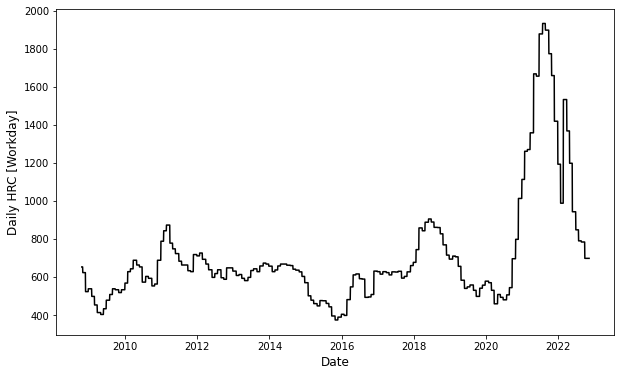

In [ ]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel(y_label, {'fontsize': 12})

timeseries(df.Date, df['Last_Wednesday_HRC'], 'Date','Daily HRC [Workday]')

In [ ]:
# Check missing values
df.isnull().sum()

Date                    0
hrc                     0
iron                    0
natural_gas             0
copper                  0
oil                     0
us_ppi                  0
us_ism_pmi              0
Weekday                 0
Month                   0
isWednesday             0
is_last_wednesday       0
Daily_Variance          0
hrc_L5                  0
hrc_L10                 0
hrc_L15                 0
quarter                 0
month                   0
year                    0
dayofyear               0
dayofmonth              0
Last_Wednesday_HRC      0
Last_Wednesday_Date    15
dtype: int64

In [ ]:
# Replace missing values by interpolation
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)

In [ ]:
# Smooth data

# Apply the Gaussian filter to the 'value' column
smoothed_data = gaussian_filter1d(df['hrc'].values, sigma=5)

# Replace the 'value' column with the smoothed data
df['hrc_smoothed'] = smoothed_data

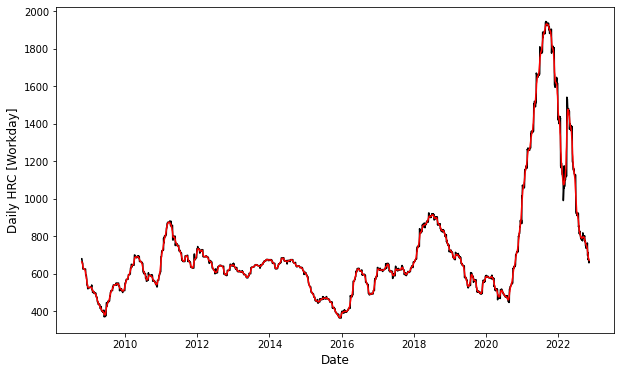

In [ ]:
# Define a function to draw time_series plot
def timeseriesCompare (x_axis, y_axis1, y_axis2, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis1, color ='black')
    plt.plot(x_axis, y_axis2, color ='red')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel(y_label, {'fontsize': 12})

timeseriesCompare(df.Date, df['hrc'], df['hrc_smoothed'], 'Date','Daily HRC [Workday]')

In [ ]:
# Replace the 'value' column with the smoothed data
df['hrc'] = smoothed_data

In [ ]:
df.columns

Index(['Date', 'hrc', 'iron', 'natural_gas', 'copper', 'oil', 'us_ppi',
       'us_ism_pmi', 'Weekday', 'Month', 'isWednesday', 'is_last_wednesday',
       'Daily_Variance', 'hrc_L5', 'hrc_L10', 'hrc_L15', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'Last_Wednesday_HRC',
       'Last_Wednesday_Date', 'hrc_smoothed'],
      dtype='object')

In [ ]:
# Split train data and test data
train_size = int(len(df)*0.95)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size: ]

In [ ]:
cutoff_date = list(train_dataset['Date'])[-1]

In [ ]:
# Drop dates
train_dataset = train_dataset.drop(['Date', 'Last_Wednesday_Date'], axis = 1)
test_dataset = test_dataset.drop(['Date', 'Last_Wednesday_Date'], axis = 1)

Dimension of train data:  (3743, 22)
Dimension of test data:  (197, 22)


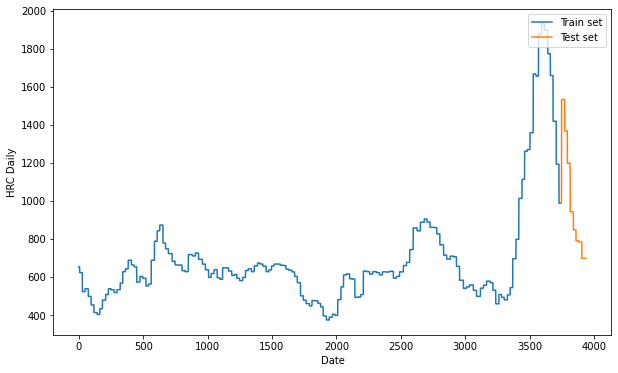

In [ ]:
# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.Last_Wednesday_HRC)
plt.plot(test_dataset.Last_Wednesday_HRC)
plt.xlabel('Date')
plt.ylabel('HRC Daily')
plt.legend(['Train set', 'Test set'], loc='upper right')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [ ]:
# Split train data to X and y
X_train = train_dataset.drop('Last_Wednesday_HRC', axis = 1)
y_train = train_dataset.loc[:,['Last_Wednesday_HRC']]
# Split test data to X and y
X_test = test_dataset.drop('Last_Wednesday_HRC', axis = 1)
y_test = test_dataset.loc[:,['Last_Wednesday_HRC']]

In [ ]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))
# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)
# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [ ]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30
X_test, y_test = create_dataset(test_x_norm, test_y_norm,   
                                TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, 
                                  TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (167, 30, 21)
y_train.shape:  (3713, 1)
X_test.shape:  (167, 30, 21)
y_test.shape:  (3713, 1)


In [ ]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

In [ ]:
# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

In [ ]:
# BiLSTM
model_bilstm = create_model_bilstm(64)
# GRU and LSTM
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

In [ ]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop])
    return history

In [ ]:
history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/100
93/93 [==============================] - 8s 25ms/step - loss: 0.0163 - val_loss: 0.0803
Epoch 2/100
93/93 [==============================] - 1s 12ms/step - loss: 0.0035 - val_loss: 0.0758
Epoch 3/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0035 - val_loss: 0.0836
Epoch 4/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0033 - val_loss: 0.0787
Epoch 5/100
93/93 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0678
Epoch 6/100
93/93 [==============================] - 1s 12ms/step - loss: 0.0033 - val_loss: 0.0573
Epoch 7/100
93/93 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0485
Epoch 8/100
93/93 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0421
Epoch 9/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0377
Epoch 10/100
93/93 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0341

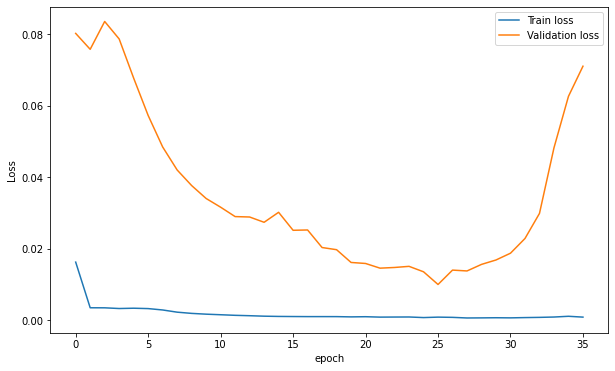

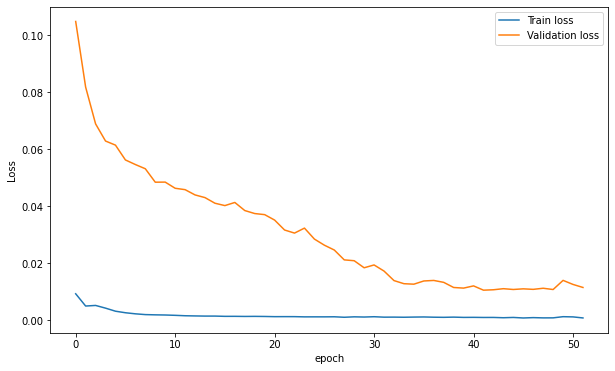

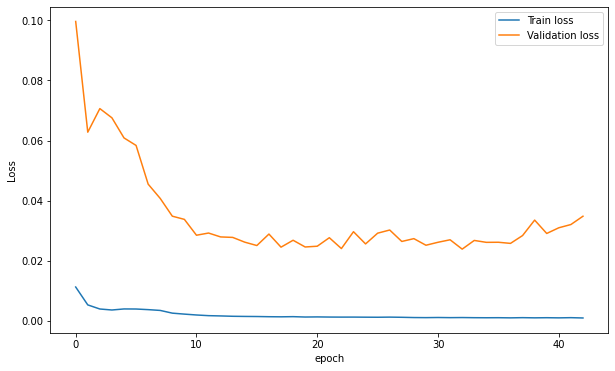

In [ ]:
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    
plot_loss (history_bilstm)
plot_loss (history_lstm)
plot_loss (history_gru)

In [ ]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

6/6 [==============================] - 1s 3ms/step


In [ ]:
len(prediction_lstm)


167

In [ ]:
results = pd.DataFrame(prediction_bilstm, columns=['prediction_bilstm'])
results['prediction_lstm'] = prediction_lstm
results['prediction_gru'] = prediction_gru
results['Date'] = np.array(df['Date'][train_size + TIME_STEPS: ])
results['Last_Wednesday_HRC'] = np.array(df['Last_Wednesday_HRC'][train_size + TIME_STEPS: ])

In [ ]:
results

,prediction_bilstm,prediction_lstm,prediction_gru,Date,Last_Wednesday_HRC
0,952.366211,1344.222412,1053.747803,2022-03-29,1535.0
1,969.651062,1354.164062,1062.171509,2022-03-30,1370.0
2,949.915833,1355.207520,1054.709717,2022-03-31,1370.0
3,962.151367,1352.493286,1063.182739,2022-04-01,1370.0
4,974.527832,1364.497681,1071.257324,2022-04-04,1370.0
...,...,...,...,...,...
162,648.788330,698.723999,655.865479,2022-11-07,700.0
163,645.209473,696.423401,649.018127,2022-11-08,700.0
164,647.941467,698.263916,652.680298,2022-11-09,700.0
165,642.030334,693.028992,649.920166,2022-11-10,700.0


In [ ]:
def plot_future():
  # Create figure with secondary y-axis
  fig = make_subplots(specs=[[{"secondary_y": True}]])

  last_wed_df = df[df['is_last_wednesday'] == 1]

  # Create figure with secondary y-axis
  fig = make_subplots(specs=[[{"secondary_y": True}]])

  # Add traces
  fig.add_trace(
      go.Scatter(x=last_wed_df.Date, y=last_wed_df['hrc'], name="HRC at last wednesday", mode="lines+markers", 
                marker=dict(
                  symbol="circle",
                  size=8,
              )),
      secondary_y=False,
  )

  fig.add_trace(
    go.Scatter(x=results.Date, y=results.prediction_bilstm, name="Daily prediction_bilstm HRC at last wednesday"),
      secondary_y=False,
  )

  fig.add_trace(
    go.Scatter(x=results.Date, y=results.prediction_lstm, name="Daily prediction_lstm HRC at last wednesday"),
      secondary_y=False,
  )

  fig.add_trace(
    go.Scatter(x=results.Date, y=results.prediction_gru, name="Daily prediction_gru HRC at last wednesday"),
      secondary_y=False,
  )

  # Add figure title
  fig.update_layout(
      title_text="Daily prediction of last wednesday of the month"
  )

  # Set x-axis title
  fig.update_xaxes(title_text="Date")

  # Set y-axes titles
  fig.update_yaxes(title_text="<b>Original</b> [Rands]", secondary_y=False)
  fig.update_yaxes(title_text="<b>Absolute Error %</b>", secondary_y=True)

  fig.add_vline(x=cutoff_date)

  fig.show()

plot_future()

6/6 [==============================] - 0s 3ms/step


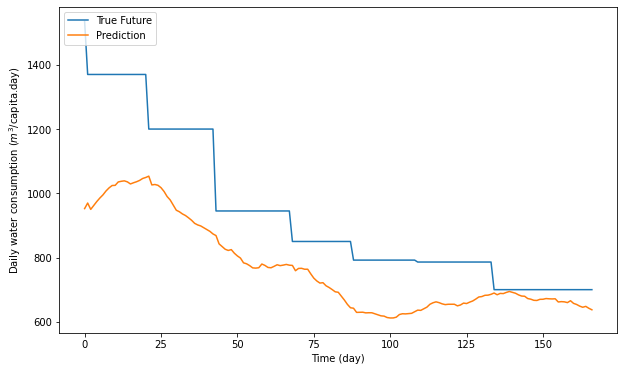

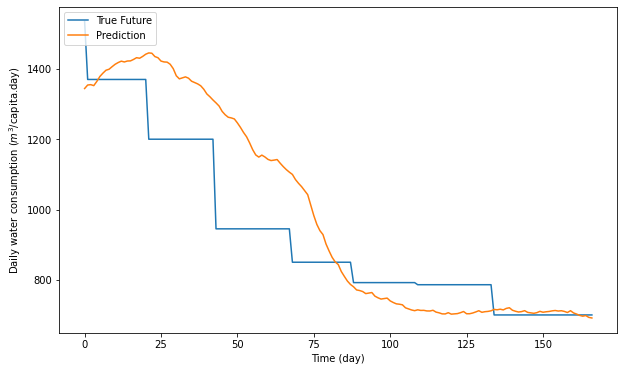

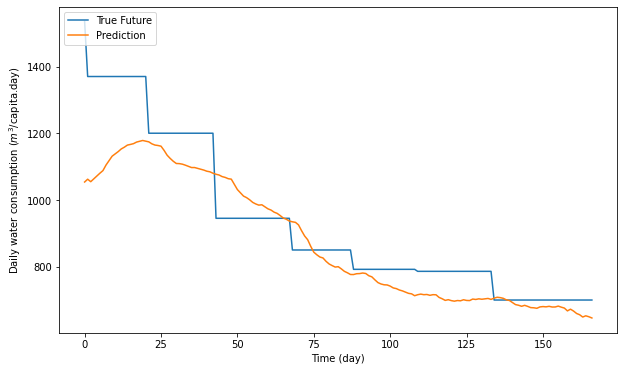

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)
# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')

plot_future(prediction_bilstm, y_test)
plot_future(prediction_lstm, y_test)
plot_future(prediction_gru, y_test)

In [ ]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

    
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 163.2091
Root Mean Square Error: 194.4572

LSTM:
Mean Absolute Error: 99.8870
Root Mean Square Error: 135.8555

GRU:
Mean Absolute Error: 79.1312
Root Mean Square Error: 110.2944



In [ ]:
# Plot histoy and future data
def plot_history_future(y_train, prediction):
    plt.figure(figsize=(10, 6))
    range_history = len(y_train)
    range_future = list(range(range_history, range_history +
                   len(prediction)))
    plt.plot(np.arange(range_history), np.array(y_train), 
             label='History')
    plt.plot(range_future, np.array(prediction),label='Prediction')
    plt.legend(loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('Last_wed__hrc')

In [ ]:
# Multi-step forecasting 
def forecast(X_input, time_steps):
    # Scale the unseen input with the scaler fitted on the train set
    X = input_scaler.transform(X_input)
    # Reshape unseen data to a 3D input
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
    X_transformed = np.array(Xs)

    # Make prediction for unseen data using LSTM model
    prediction = model_bilstm.predict(X_transformed)
    prediction_actual = scaler_y.inverse_transform(prediction)
    return prediction_actual
      

In [ ]:
df.columns

Index(['Date', 'hrc', 'iron', 'natural_gas', 'copper', 'oil', 'us_ppi',
       'us_ism_pmi', 'Weekday', 'Month', 'isWednesday', 'is_last_wednesday',
       'Daily_Variance', 'hrc_L5', 'hrc_L10', 'hrc_L15', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'Last_Wednesday_HRC',
       'Last_Wednesday_Date', 'hrc_smoothed'],
      dtype='object')

2/2 [==============================] - 0s 11ms/step


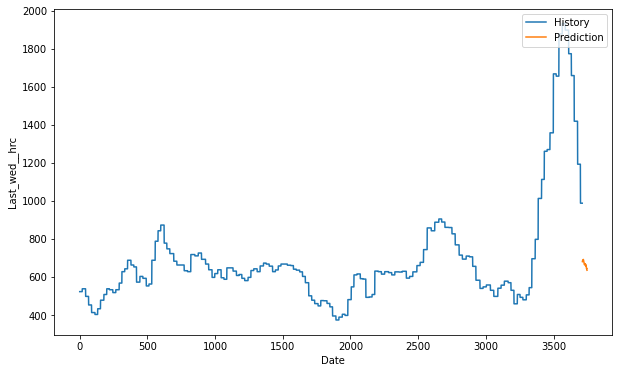

In [ ]:
X_new = df[['hrc', 'iron', 'natural_gas', 'copper', 'oil', 'us_ppi',
       'us_ism_pmi', 'Weekday', 'Month', 'isWednesday', 'is_last_wednesday',
       'Daily_Variance', 'hrc_L5', 'hrc_L10', 'hrc_L15', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'hrc_smoothed']][-65:]

prediction = forecast(X_new, TIME_STEPS)
plot_history_future(y_train, prediction)